In [1]:
import sys
sys.path += [".."]

import smbh
from math import *
import numpy as np
from scipy.special import erf
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Sound speed

$$
    c_s = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}T_\text{vir}} = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}\left(\dfrac{\mu m_p G M_h}{2k_BR_\text{vir}}\right)} = \sqrt{\dfrac{\gamma R\mu m_pG}{2\mathcal{M}_wk_B}} \sqrt{\dfrac{M_h}{R_\text{vir}}} \approx 0.614 \sqrt{\dfrac{M_h}{R_\text{vir}}}\text{ kpcGyr$^{-1}$}
$$

In [2]:
from scipy.constants import m_p, k, R
smbh.SOLAR_MASSES * 1e5, m_p

mu = 1.1
gamma = 5 / 3

f = ((gamma * R * mu * m_p * smbh.G) / (2 * k * (mu / 1000)))
f = f ** 0.5
print(f, f * (1e3 / smbh.R_VIR_z20) ** 0.5)

0.6141441129704023 23.38051630990129


In [3]:
def soundSpeedChoksi(mh, z):
    kms = 1.8 * (1 + z) ** 0.5 * (mh / 100) ** (1/3) * (0.304 * (0.678 ** 2) / 0.14) ** (1 / 6)
    return smbh.kmsTokpcGyr(kms)

In [4]:
soundSpeedChoksi(1e3, 20)

18.169224634725687

# Mach function zero

$$
    \ln\Lambda\left[1.5\left(\erf{\dfrac{\mathcal{M}}{\sqrt{2}}} - \sqrt{\dfrac{2}{\pi}}\mathcal{M}e^{-\mathcal{M}^2/2}\right) - 1\right] - 0.5\ln\left(1 - \mathcal{M}^{-2}\right) = 0
$$

In [5]:
def mach(m, lnL = 2.3):
    factor = erf(m / sqrt(2)) - sqrt(2 / np.pi) * m * np.exp(-(m ** 2) / 2)
    f1 = 1.5 * lnL * factor
    f2 = 0.5 * np.log(1 - (m ** -2)) + lnL
    return f1 - f2

fsolve(mach, 1.7)

array([1.73100478])

# Scale length approx
$$
	\mathcal{R}_s = \dfrac{0.01}{\left(1 + \sqrt{2}\right)}\left({\dfrac{M_hG}{100 H(t)^2}}\right)^{1/3}
$$

In [6]:
a = 0.01 / (1 + sqrt(2)) * (smbh.G / 100) ** (1/3)
print("%e" % a)

6.835160e-04


# Density profiles

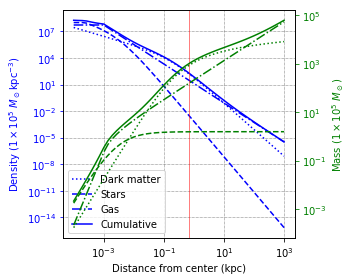

In [7]:
r = np.logspace(-4, 3)

smbh.setBaryonicFraction(0.156)
smbh.setGasPower(-2.2)

smbh.setStellarRatio(0.01)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs01.png", dpi = 300)

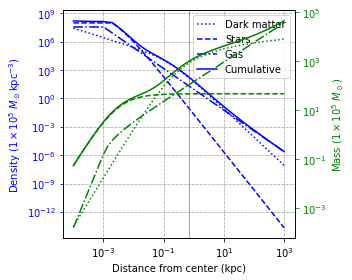

In [8]:
smbh.setStellarRatio(0.3)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs3.png", dpi = 300)

# Single orbits

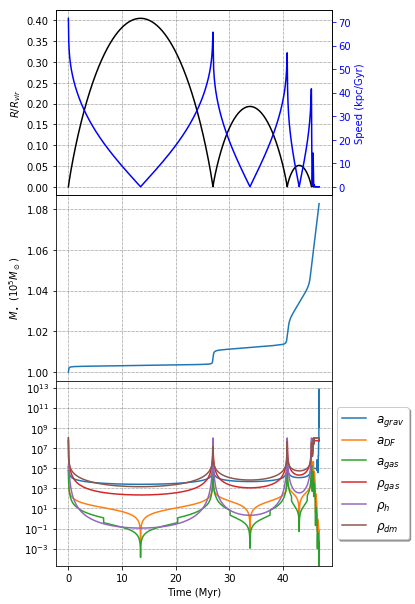

In [12]:
v0 = 70 * 1.023 # to kpc / gyr

dt = 1e-6
smbh_m = 1

smbh.setStellarRatio(0.01)

smbh.setGasPower(-2.2)
result = smbh.run([v0, 0, 0], smbh_m, save_every = 10)

fig, (ax1, ax2, ax3) = smbh.plotProperties(result)

fig.savefig('properties_s01v70.png', dpi = 300)

plt.show()

# Power law

In [10]:
v0 = 70 * 1.023 # to kpc / gyr

dt = 1e-6
smbh_m = 1

smbh.setStellarRatio(0.01)

In [11]:
powers = [-1.8, -1.9, -2, -2.1, -2.2, -2.3]

results = []
for power in powers:
    smbh.setGasPower(power)
    result = smbh.run([v0, 0, 0], smbh_m, save_every = 10)
    results.append(result)

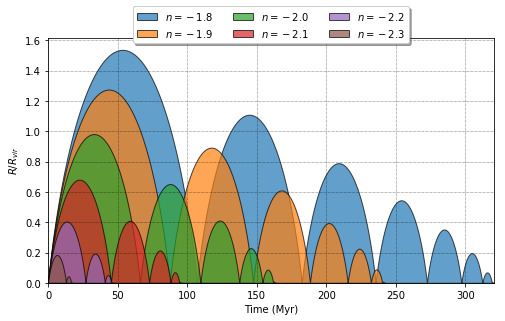

In [12]:
labels = ["$n = %.1f$" % n for n in powers]
fig, ax = smbh.plotOrbits(results)

smbh.coolLegend(ax, labels, ncol = 3)

fig.savefig("power_law.png", dpi = 300)
plt.show()

# Stellar fraction results

In [2]:
ratios = np.linspace(0.01, 0.1, 50)
speeds = np.linspace(65, 85, 4).astype(int)
results = np.zeros((len(speeds), len(ratios)), dtype = object)

file = "Data/return_%d_%d.dat" 

In [3]:
smbh.setR_vir(smbh.R_VIR_z20)
smbh.setGasPower(-2.2)
for (i, speed) in enumerate(speeds):
    speed = smbh.kmsTokpcGyr(speed)
    for (j, ratio) in enumerate(ratios):
        smbh.setStellarRatio(ratio)
        result = smbh.run([speed, 0, 0], save_every = 10)#, filename = file%(i, j))
        results[i, j] = result

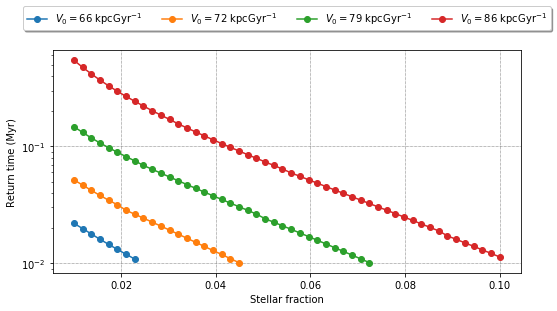

In [4]:
fig, ax = plt.subplots(figsize = (8, 4.5))

for row in results:
    ratios = np.array([result.STELLAR_FRACTION for result in row])
    times = np.array([result.getReturnTime() for result in row])
    speed = row[0].speed[0]
    try:
        pos = np.where(times <= 0.01)[0][0]
        times = times[:pos]
        ratios = ratios[:pos]
    except IndexError: pass
    ax.plot(ratios, times, "-o", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    
ax.set_xlabel("Stellar fraction")
ax.set_ylabel("Return time (Myr)")

ax.set_yscale("log")
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.22),
          ncol = 4, fancybox = True, shadow = True)
ax.grid()

fig.tight_layout()
# fig.savefig("returntimes_stellar_speed.png", dpi = 300)

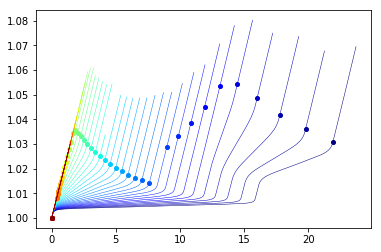

In [30]:
n = len(ratios)
colors = smbh.getColors(n)

for i in range(n):
    result = results[0, i]
    rt = result.getReturnTime()
    rm = result.masses[result.return_index]
    plt.plot(1000 * result.times, result.masses, c = colors[i], alpha = 1, lw = 0.5)
    plt.plot([1000 * rt], [rm], "o", ms = 4, c = colors[i][:3])

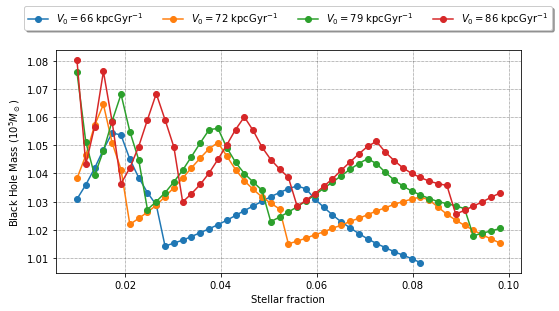

In [5]:
fig, ax = plt.subplots(figsize = (8, 4.5))

for row in results:
    speed = row[0].speed[0]
    ratios = np.array([result.STELLAR_FRACTION for result in row])
    masses = np.array([result.getMassAtReturnTime() for result in row])
    try: pos = np.where(masses <= 1.001)[0][0]
    except IndexError: pos = -1
    ratios = ratios[: pos]
    masses = masses[: pos]
    ax.plot(ratios, masses, "-o", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    
ax.set_xlabel("Stellar fraction")
ax.set_ylabel("Black Hole Mass ($10^5 M_\odot$)")

# ax.set_yscale("log")
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.22),
          ncol = 4, fancybox = True, shadow = True)
ax.grid()

fig.tight_layout()

fig.savefig("mass_stellar_speed.png", dpi = 300)

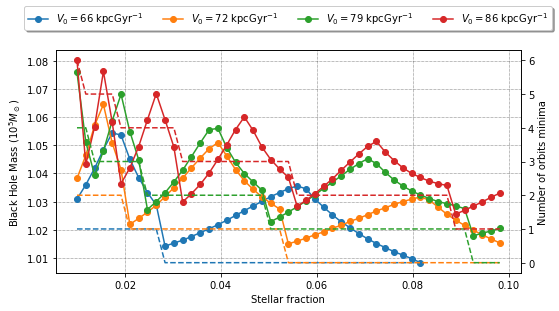

In [6]:
fig, ax = plt.subplots(figsize = (8, 4.5))

ax1 = ax.twinx()
for row in results:
    speed = row[0].speed[0]
    ratios = np.array([result.STELLAR_FRACTION for result in row])
    masses = np.array([result.getMassAtReturnTime() for result in row])
    minimas = np.array([len(smbh.findLocalMinima(result.distance[: result.return_index])) for result in row])
    try: pos = np.where(masses <= 1.001)[0][0]
    except IndexError: pos = -1
    ratios = ratios[: pos]
    masses = masses[: pos]
    minimas = minimas[: pos]
    ax.plot(ratios, masses, "-o", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    ax1.plot(ratios, minimas, "--", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    
ax.set_xlabel("Stellar fraction")
ax.set_ylabel("Black Hole Mass ($10^5 M_\odot$)")
ax1.set_ylabel("Number of orbits minima")

# ax.set_yscale("log")
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.22),
          ncol = 4, fancybox = True, shadow = True)
ax.grid()

fig.tight_layout()
fig.savefig("mass_stellar_speed_2.png", dpi = 300)

/home/juan/.tesisFisica/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/home/juan/.tesisFisica/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


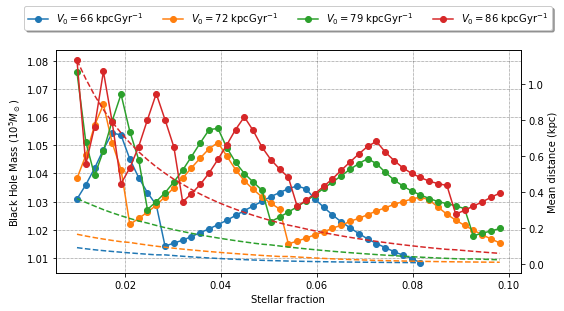

In [7]:
fig, ax = plt.subplots(figsize = (8, 4.5))

ax1 = ax.twinx()
for row in results:
    speed = row[0].speed[0]
    ratios = np.array([result.STELLAR_FRACTION for result in row])
    masses = np.array([result.getMassAtReturnTime() for result in row])
    mean = np.array([result.distance[: result.return_index].mean() for result in row])
    try: pos = np.where(masses <= 1.001)[0][0]
    except IndexError: pos = -1
    ratios = ratios[: pos]
    masses = masses[: pos]
    mean = mean[: pos]
    ax.plot(ratios, masses, "-o", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    ax1.plot(ratios, mean, "--", label = "$V_0 = %d$ kpcGyr$^{-1}$"%speed)
    
ax.set_xlabel("Stellar fraction")
ax.set_ylabel("Black Hole Mass ($10^5 M_\odot$)")
ax1.set_ylabel("Mean distance (kpc)")
# ax.set_yscale("log")
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.22),
          ncol = 4, fancybox = True, shadow = True)
ax.grid()

fig.tight_layout()
fig.savefig("mass_stellar_speed_3.png", dpi = 300)